In [129]:
from transformers import PaliGemmaForConditionalGeneration,PaliGemmaProcessor,SiglipModel
from safetensors.torch import load_file
from PIL import Image

import re
import torch
from PIL import ImageDraw, ImageFont

torch.set_grad_enabled(False)

torch.autograd.grad_mode.set_grad_enabled(mode=False)

In [130]:
def draw_paligemma_boxes(image, model_output, width=3):
    img = image.copy()
    draw = ImageDraw.Draw(img)
    W, H = img.size
    colors = {
        "molar": "red",
        "premolar": "blue", 
        "canine": "green",
        "incisor": "orange",
        "unknown": "grey",
        "tooth": "cyan",
        "problem tooth": "magenta"
    }
    pattern = r"<loc(\d{4})><loc(\d{4})><loc(\d{4})><loc(\d{4})>\s*([^;<]+)"
    matches = re.findall(pattern, model_output)
    for ymin, xmin, ymax, xmax, label in matches:
        ymin = int(ymin)
        xmin = int(xmin)
        ymax = int(ymax)
        xmax = int(xmax)
        x1 = xmin / 1023 * W
        y1 = ymin / 1023 * H
        x2 = xmax / 1023 * W
        y2 = ymax / 1023 * H
        label_lower = label.strip().lower()
        color = colors.get(label_lower, "grey")
        draw.rectangle([x1, y1, x2, y2], outline=color, width=width)
        draw.text((x1, y1 - 10), label.strip(), fill=color)
    return img

In [256]:
model = PaliGemmaForConditionalGeneration.from_pretrained("justacoderwhocodes/paligemma-dental-bbox-simplified",dtype=torch.bfloat16) #paligemma-dental-bbox-simplified OR paligemma-dental-bounding-boxes
processor = PaliGemmaProcessor.from_pretrained("google/paligemma2-3b-pt-448",dtype=torch.bfloat16)
medsiglip = SiglipModel.from_pretrained("google/medsiglip-448",dtype=torch.bfloat16)

Loading weights: 100%|██████████| 888/888 [00:04<00:00, 214.27it/s, Materializing param=vision_model.post_layernorm.weight]                      


In [225]:
# model = PaliGemmaForConditionalGeneration.from_pretrained("trained_1000_steps",dtype=torch.bfloat16)

In [226]:
# medsiglip_state_dict = medsiglip.vision_model.state_dict()
# head_keys = [key for key in medsiglip_state_dict.keys() if 'head' in key]
# filtered_state_dict_no_head = {
#     k: v for k, v in medsiglip_state_dict.items() 
#     if not k.startswith("head.")
# }

In [227]:
# model.model.vision_tower.vision_model.load_state_dict(filtered_state_dict_no_head, strict=True)

In [257]:
model = model.to("mps")
model = model.eval()

In [258]:
image = Image.open("dataset_mixed_bbox/opg_254.jpg")
# prompt = "<image><bos>detect canine; detect incisor; detect molar; detect premolar;"
prompt = "<image><bos>detect tooth; detect problem tooth;"

In [259]:
inputs = processor(images=image,text=prompt,return_tensors="pt")

In [260]:
for k in inputs:
    inputs[k] = inputs[k].to("mps")

In [261]:
temp = model.generate(**inputs,max_new_tokens=384)
result = processor.decode(temp,skip_special_tokens=False)

In [262]:
print(result[0].replace("<image>",""))

<bos><bos>detect tooth; detect problem tooth;
<loc0403><loc0284><loc0497><loc0337> tooth; <loc0415><loc0454><loc0526><loc0494> tooth; <loc0402><loc0486><loc0538><loc0528> tooth; <loc0414><loc0515><loc0535><loc0563> tooth; <loc0420><loc0566><loc0530><loc0598> tooth; <loc0418><loc0605><loc0530><loc0646> tooth; <loc0411><loc0652><loc0523><loc0690> tooth; <loc0411><loc0694><loc0501><loc0739> tooth; <loc0480><loc0751><loc0565><loc0831> tooth; <loc0509><loc0690><loc0607><loc0790> tooth; <loc0544><loc0626><loc0644><loc0666> tooth; <loc0553><loc0591><loc0651><loc0625> tooth; <loc0555><loc0561><loc0657><loc0594> tooth; <loc0548><loc0538><loc0651><loc0561> tooth; <loc0549><loc0513><loc0645><loc0540> tooth; <loc0555><loc0485><loc0651><loc0510> tooth; <loc0546><loc0451><loc0651><loc0488> tooth; <loc0534><loc0409><loc0651><loc0450> tooth; <loc0524><loc0373><loc0631><loc0414> tooth; <loc0520><loc0323><loc0626><loc0387> tooth; <loc0514><loc0274><loc0609><loc0355> tooth; <loc0351><loc0722><loc0487><lo

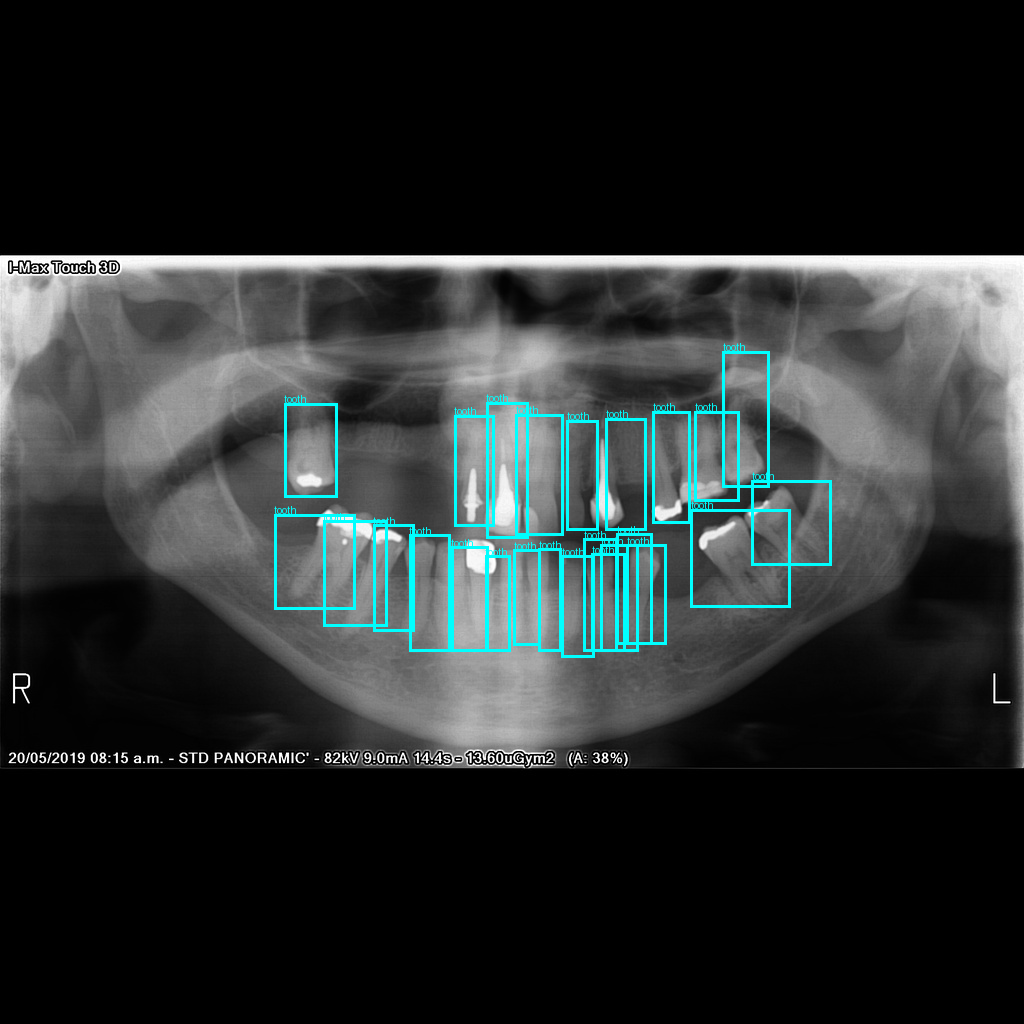

In [263]:
draw_paligemma_boxes(image,result[0])

From mixed trained model (panoramic_img128)

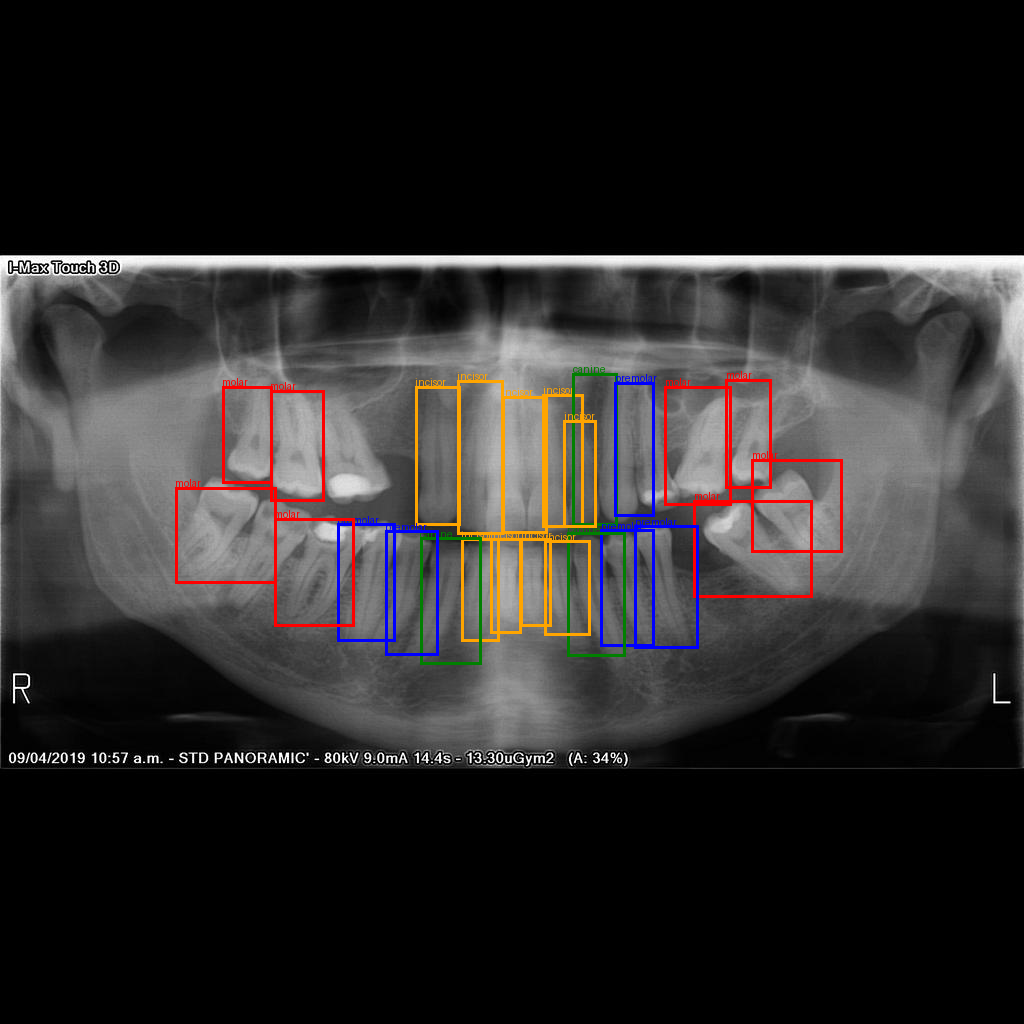

In [ ]:
draw_paligemma_boxes(image,result[0]) #img128